# How to Properly Plot Uncertainty Ellipses for 2D Normally Distributed Data

Copyright &copy; 2020 [Joshua A. Marshall](https://www.ece.queensu.ca/people/j-marshall)

This notebook demonstrates how to properly plot ellipses in $\mathbb{R}^2$ that represent desired levels of uncertainty as given by the covariance matrix of normally distributed data in 2D.  The reason for this notebook is that I have seen others naively extend 1D covariance bounds to 2D, which is technically not correct.  References are provided in the [README.md](README.md) file.

We use [NumPy](https://numpy.org).

In [1]:
import numpy as np

## Special Case: Diagonal Covariance Matrix

Suppose $\mathbf{x}=(x_1, x_2)\in\mathbb{R}^2$ is a Gaussian (i.e., normally distributed) random variable.  Suppose $\mathbf{x}$ has mean $\bar{\mathbf{x}}$ and covariance matrix $\mathbf{P}\in\mathbb{R}^{2\times 2}$, where $\mathbf{P}$ is necessarily postive semi-definite and symmetric.  Thus, we write $\mathbf{x}\sim\mathcal{N}_2(\bar{\mathbf{x}},\mathbf{P})$ with $|\mathbf{P}|>0$ and in our Python code we use the `x`, `x_mean`, and `P`.  Let's start with the case when our data is aligned with the $x_1$ and $x_2$ axes (i.e., the covariance matrix $\mathbf{P}$ is conveniently diagonal).

First, generate some normally distributed test data in 2D.  Sample a large enough number $n\gg 0$ points as `n`.

In [2]:
n = 1000

In [3]:
x_mean = np.array([1.0, 2.0])
P = np.diag([2.0, 1.0])
x = np.zeros((2, n))
x[0, :] = x_mean[0] + np.sqrt(P[0, 0])*np.random.randn(1, n)
x[1, :] = x_mean[1] + np.sqrt(P[1, 1])*np.random.randn(1, n)

Let's look at the data using [Matplotlib](https://matplotlib.org).

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

The options are ... optional.

In [5]:
%config InlineBackend.figure_format = 'svg'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright,amsmath}')

Plot the data.  Make sure that both axes use the same scale, for proper viewing.

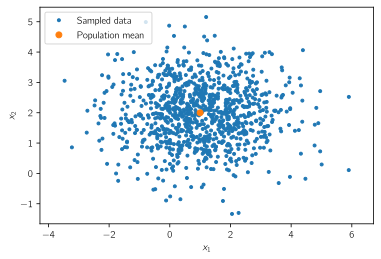

In [6]:
fig1 = plt.figure(1)
plt.plot(x[0, :], x[1, :], 'C0.', label='Sampled data')
plt.plot(x_mean[0], x_mean[1],'C1o', label='Population mean')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper left')
plt.axis('equal')
plt.show()

Now, let's create an ellipse that contains a fraction $1-\alpha$ of the data as $n\rightarrow\infty$, where $0<\alpha<1$.  E.g., for an ellipse that represents $95 \%$ of the data use $\alpha=0.05$; for $99 \%$ use $\alpha =0.01$.

We employ the following result, which can be found in Johnson and Wichern (2007) [Applied Multivariate Statistical Anlaysis](https://ocul-qu.primo.exlibrisgroup.com/permalink/01OCUL_QU/11tsvcl/alma9925738833405158) (6th ed.), Chapter 4, Result 4.7 on page 163:

> Let $\mathbf{x}\sim\mathcal{N}_p(\bar{\mathbf{x}},\mathbf{P})$ with $|\mathbf{P}|>0$. Then
> 1. $(\mathbf{x}-\bar{\mathbf{x}})^\top \mathbf{P}^{-1} (\mathbf{x}-\bar{\mathbf{x}})$ is distributed as $\chi^2_p$, where $\chi^2_p$ denotes the chi-square distribution with $p$ degress of freedom.
> 2. The $\mathcal{N}_p(\bar{\mathbf{x}},\mathbf{P})$ distribution assigns proability $1-\alpha$ to the solid ellipsoid $\{\mathbf{x}:(\mathbf{x}-\bar{\mathbf{x}})^\top \mathbf{P}^{-1} (\mathbf{x}-\bar{\mathbf{x}})\leq \chi^2_p(\alpha)\}$, where $\chi^2_p(\alpha)$ denotes the upper $(100\alpha)$-th percentile of the $\chi^2_p$ distribution.

Let's use the `chi2` function from [SciPy](http://scipy.org) and use `p` for the degress of freedom $p$ and `alpha` for the fraction $\alpha$. 

In [7]:
from scipy.stats import chi2

In [8]:
p = 2
alpha = 0.05

Now, compute the scale of the ellipse using the $\chi^2$ inverse cumulative distrubution function as `s`.

In [9]:
s = chi2.isf(alpha, p)
print(s)

5.991464547107983


We need the `patches` function from Matlplotlib to make a plot of our ellipse.

In [10]:
from matplotlib import patches

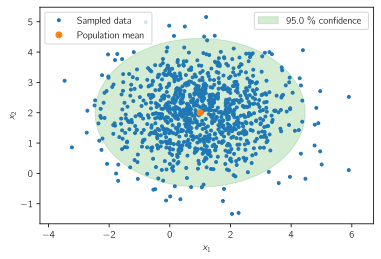

In [11]:
fig2, ax2 = plt.subplots()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.plot(x[0, :], x[1, :], 'C0.', label='Sampled data')
plt.plot(x_mean[0], x_mean[1],'C1o', label='Population mean')
first_legend = plt.legend(loc='upper left')
ell = patches.Ellipse((x_mean[0], x_mean[1]), 
                      2.0*np.sqrt(s*P[0,0]), 2.0*np.sqrt(s*P[1,1]),
                      angle=0, alpha=0.2, color='C2')
ax2.add_artist(ell)
plt.axis('equal')
ax2 = plt.gca().add_artist(first_legend)
plt.legend([ell],[str(100*(1-alpha)) + ' \% confidence'], loc='upper right')
plt.show()

## General Case: Covariance Matrix is Not Diagonal

Now, let's consider the case when our data is not aligned with the coordinate system.  In the general case, $\mathbf{P}$ is not diagonal.  For the purposes of this example we'll just rotate our old data by some angle $\theta$ such that $\mathbf{x}' = \mathbf{R}(\theta)\mathbf{x}$ and $\mathbf{P}' = \mathbf{R}(\theta)^\top\mathbf{P}\mathbf{R}(\theta)$.  For an estimation problem (i.e., where we estimate the mean and convariance from sampled data), you would  have computed a covariance matrix $\mathbf{P}$ that is not necessarily diagonal, making the following the general approach; see the next section.

In [12]:
theta = np.pi/4
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
x = R@x
x_mean = R@x_mean
P = R.transpose()@P@R
print(x_mean)
print(P)

[-0.70710678  2.12132034]
[[ 1.5 -0.5]
 [-0.5  1.5]]


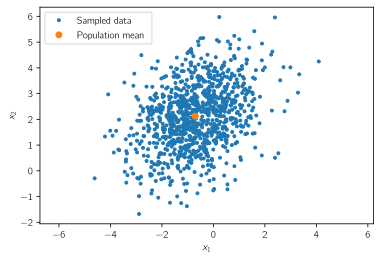

In [13]:
fig3 = plt.figure(1)
plt.plot(x[0, :], x[1, :], 'C0.', label='Sampled data')
plt.plot(x_mean[0], x_mean[1],'C1o', label='Population mean')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper left')
plt.axis('equal')
plt.show()

Now, let's back-compute the angle of the ellipse from the covariance matrix $\mathbf{P}$.  We compute the eigenvlaues and the eigenvectors of the matrix $\mathbf{P}$.

In [14]:
W, V = np.linalg.eig(P)

The eigenvalues (and corresponding eigenvectors) are not necessarily ordered.  So, let's find the index of the largest eigenvalue and the index of the smallest eigenvalue so that we plot the major and minor axes in the correct directions.

In [15]:
j_max = np.argmax(W)
j_min = np.argmin(W)

Now plot the data and the corresponding uncertainty ellipse.

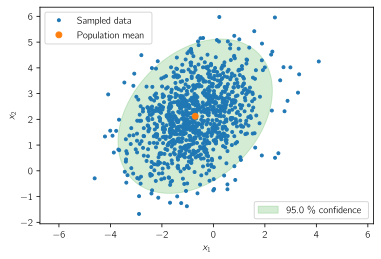

In [16]:
fig4, ax4 = plt.subplots()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.plot(x[0, :], x[1, :], 'C0.', label='Sampled data')
plt.plot(x_mean[0], x_mean[1],'C1o', label='Population mean')
first_legend = plt.legend(loc='upper left')
ell = patches.Ellipse((x_mean[0], x_mean[1]), 
                      2.0*np.sqrt(s*W[j_max]), 2.0*np.sqrt(s*W[j_min]),
                      angle=np.arctan2(V[j_max,1], V[j_max,0])*180/np.pi, 
                      alpha=0.2, color='C2')
ax4.add_artist(ell)
plt.axis('equal')
ax4 = plt.gca().add_artist(first_legend)
plt.legend([ell],[str(100*(1-alpha)) + ' \% confidence'], loc='lower right')
plt.show()

## Using the Sample Mean and Covariance

Note that, in all of the above examples, we use the true population mean and the popluation covariance.  The plot below uses the sample mean and sample convariance, which is more representative of a sampled data scenario.

First, compute the sample mean $\bar{\mathbf{x}}$ as `x_bar` and the sample covariance $\bar{\mathbf{P}}$ as `P_bar`.

In [17]:
x_bar = np.array([np.mean(x[0, :]), np.mean(x[1, :])])
P_bar = np.cov(x)
print(x_bar)
print(P_bar)

[-0.69135871  2.10242331]
[[1.50804144 0.51813893]
 [0.51813893 1.53664049]]


Now, recompute the eigenvalues and eigenvectors before plotting the result.

In [18]:
W, V = np.linalg.eig(P)
j_max = np.argmax(W)
j_min = np.argmin(W)

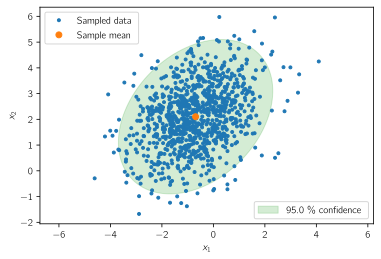

In [19]:
fig5, ax5 = plt.subplots()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.plot(x[0, :], x[1, :], 'C0.', label='Sampled data')
plt.plot(x_bar[0], x_bar[1],'C1o', label='Sample mean')
first_legend = plt.legend(loc='upper left')
ell = patches.Ellipse((x_bar[0], x_bar[1]), 
                      2.0*np.sqrt(s*W[j_max]), 2.0*np.sqrt(s*W[j_min]),
                      angle=np.arctan2(V[j_max,1], V[j_max,0])*180/np.pi, 
                      alpha=0.2, color='C2')
ax5.add_artist(ell)
plt.axis('equal')
ax4 = plt.gca().add_artist(first_legend)
plt.legend([ell],[str(100*(1-alpha)) + ' \% confidence'], loc='lower right')
plt.show()

## Sanity Check for 1D the Case

As a sanity check, let's verify that our methodolgy works as expected when the degrees of freedom is now $p=1$.  

In [20]:
p = 1
s = chi2.isf(alpha, p)
print(s**0.5)

1.959963984540055


Notice that we get [the expected result for a 1D Gaussian](https://commons.wikimedia.org/wiki/File:The_Normal_Distribution.svg#/media/File:The_Normal_Distribution.svg) with a $z$-score of $1.96$ corresponding to a $95 \%$ confidence bound.